# Thompson Sampling

In [2]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from mclearn.active import run_bandit_expt
from mclearn.heuristics import (random_h, entropy_h, margin_h, qbb_kl_h, qbb_margin_h,
                               pool_entropy_h, pool_variance_h)
from mclearn.tools import results_exist, load_results
from mclearn.preprocessing import balanced_train_test_split
from mclearn.viz import (plot_average_learning_curve, plot_heuristic_selections,
                         plot_bandit_parameters)
%matplotlib inline
plt.style.use('ggplot')

In [4]:
fig_dir = '../thesis/figures/'
target_col = 'class'
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']
vstatlas_features = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

## SDSS Dataset

In [ ]:
sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X = np.array(sdss[sdss_features])
X_poly = transformer.fit_transform(X)
y = np.array(sdss[target_col])

### Balanced: Logistic Regression

In [ ]:
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
logistic_committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1, max_samples=300)

fast_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h]

X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=900000, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [15]:
fast_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']
pickle_paths = ['../pickle/07_thompson_sampling/sdss_balanced_logistic_lcs.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_heuristics.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, logistic, logistic_committee, fast_heuristics, pickle_paths)

bl_lcs, bl_heuristics, bl_mus, bl_sigmas, bl_candidates = load_results(pickle_paths)

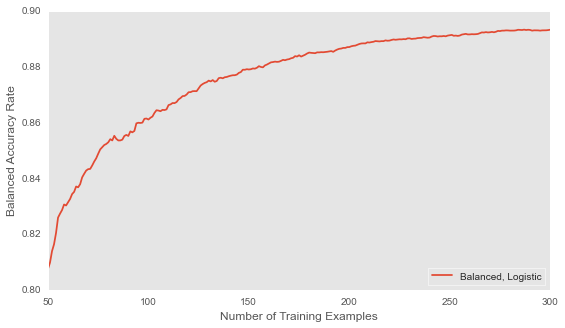

In [16]:
fig = plt.figure(figsize=(9, 5))
ax = plot_average_learning_curve(np.arange(50, 301), [bl_lcs], ['Balanced, Logistic'])
fig.savefig(fig_dir + '5_thompson/sdss_bl_lcs.pdf', bbox_inches='tight')

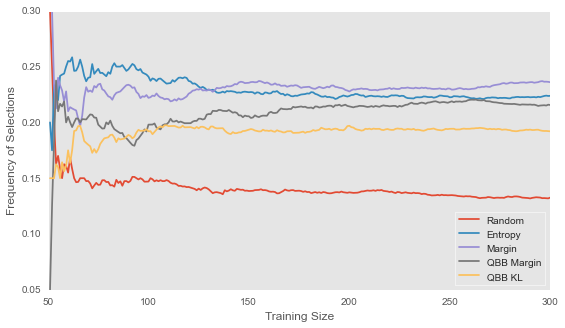

In [17]:
fig = plt.figure(figsize=(9, 5))
ax = plot_heuristic_selections(np.arange(51, 301), bl_heuristics, fast_labels)
fig.savefig(fig_dir + '5_thompson/sdss_bl_heuristics.pdf', bbox_inches='tight')

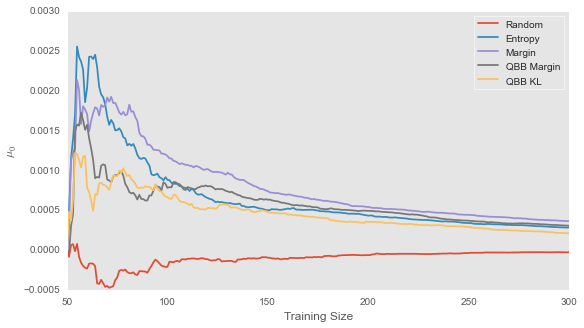

In [18]:
fig = plt.figure(figsize=(9, 5))
ax = plot_bandit_parameters(np.arange(50, 301), bl_mus, fast_labels, ylabel='$\mu_0$')
fig.savefig(fig_dir + '5_thompson/sdss_bl_mus.pdf', bbox_inches='tight')

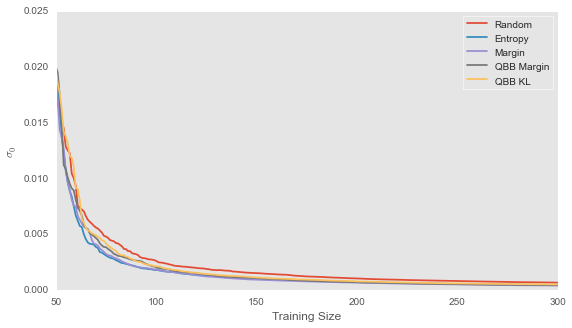

In [19]:
fig = plt.figure(figsize=(9, 5))
ax = plot_bandit_parameters(np.arange(50, 301), bl_sigmas, fast_labels, ylabel='$\sigma_0$')
fig.savefig(fig_dir + '5_thompson/sdss_bl_sigmas.pdf', bbox_inches='tight')

### Balanced: SVM RBF

In [ ]:
rbf = SVC(kernel='rbf', gamma=0.001, C=10000, cache_size=2000, class_weight='auto', probability=True)
rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

all_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
all_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy']

X_pool, _, y_pool, _ = balanced_train_test_split(X, y, train_size=900000, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/sdss_balanced_rbf_lcs.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_heuristics.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, rbf, rbf_committee, all_heuristics, pickle_paths)

br_lcs, br_heuristics, br_mus, br_sigmas, br_candidates = load_results(pickle_paths)

### Unbalanced: Logistic Regreesion

In [ ]:
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
logistic_committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1, max_samples=300)

fast_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h]
fast_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/sdss_unbalanced_logistic_lcs.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_heuristics.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_poly, y, kfold, logistic, logistic_committee, fast_heuristics, pickle_paths)

ul_lcs, ul_heuristics, ul_mus, ul_sigmas, ul_candidates = load_results(pickle_paths)

### Unbalanced: SVM RBF

In [ ]:
rbf = SVC(kernel='rbf', gamma=0.001, C=10000, cache_size=2000, class_weight='auto', probability=True)
rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

all_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
all_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy']

kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/sdss_unbalanced_rbf_lcs.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_heuristics.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X, y, kfold, rbf, rbf_committee, all_heuristics, pickle_paths)

ur_lcs, ur_heuristics, ur_mus, ur_sigmas, ur_candidates = load_results(pickle_paths)

## VST ATLAS Dataset

In [ ]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X = np.array(vstatlas[vstatlas_features])
X_poly = transformer.fit_transform(X)
y = np.array(vstatlas[target_col])

### Balanced: Logistic Regression

In [ ]:
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=100, random_state=2, class_weight='auto')
logistic_committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1, max_samples=300)

fast_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h]

X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

In [8]:
fast_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']
pickle_paths = ['../pickle/07_thompson_sampling/vstatlas_balanced_logistic_lcs.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_logistic_heuristics.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, logistic, logistic_committee, fast_heuristics, pickle_paths)

bl_lcs, bl_heuristics, bl_mus, bl_sigmas, bl_candidates = load_results(pickle_paths)

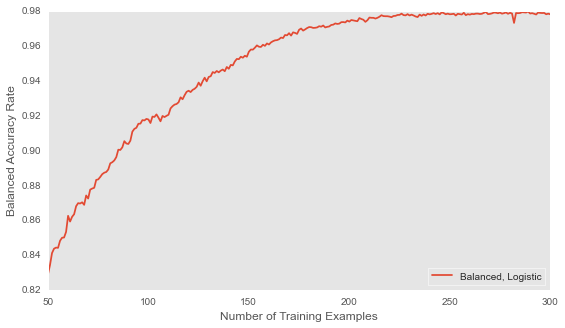

In [9]:
fig = plt.figure(figsize=(9, 5))
ax = plot_average_learning_curve(np.arange(50, 301), [bl_lcs], ['Balanced, Logistic'])
fig.savefig(fig_dir + '5_thompson/vstatlas_bl_lcs.pdf', bbox_inches='tight')

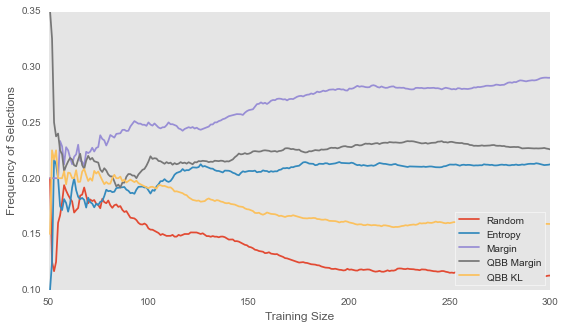

In [11]:
fig = plt.figure(figsize=(9, 5))
ax = plot_heuristic_selections(np.arange(51, 301), bl_heuristics, fast_labels)
fig.savefig(fig_dir + '5_thompson/vstatlas_bl_heuristics.pdf', bbox_inches='tight')

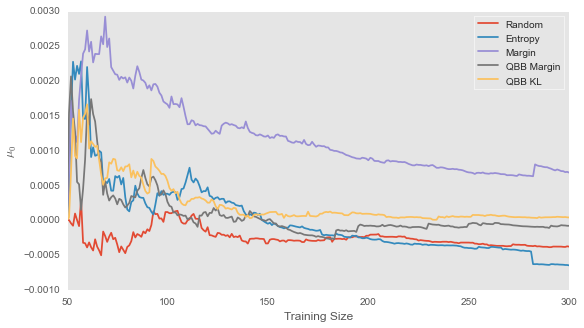

In [12]:
fig = plt.figure(figsize=(9, 5))
ax = plot_bandit_parameters(np.arange(50, 301), bl_mus, fast_labels, ylabel='$\mu_0$')
fig.savefig(fig_dir + '5_thompson/vstatlas_bl_mus.pdf', bbox_inches='tight')

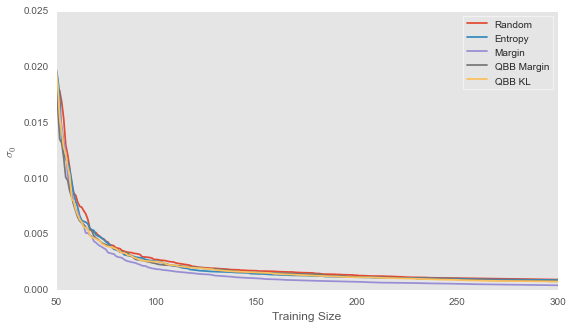

In [13]:
fig = plt.figure(figsize=(9, 5))
ax = plot_bandit_parameters(np.arange(50, 301), bl_sigmas, fast_labels, ylabel='$\sigma_0$')
fig.savefig(fig_dir + '5_thompson/vstatlas_bl_sigmas.pdf', bbox_inches='tight')

### Balanced: SVM RBF

In [ ]:
rbf = SVC(kernel='rbf', gamma=0.001, C=10000, cache_size=2000, class_weight='auto', probability=True) # NEED TO TUNE HYPERPARAMETERS
rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

all_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
all_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy']

X_pool, _, y_pool, _ = balanced_train_test_split(X, y, train_size=2360, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/vstatlas_balanced_rbf_lcs.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_rbf_heuristics.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/vstatlas_balanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, rbf, rbf_committee, all_heuristics, pickle_paths)

br_lcs, br_heuristics, br_mus, br_sigmas, br_candidates = load_results(pickle_paths)

### Unbalanced: Logistic Regreesion

In [ ]:
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=100, random_state=2, class_weight='auto')
logistic_committee = BaggingClassifier(logistic_classifier, n_estimators=11, n_jobs=-1, max_samples=300)

fast_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h]
fast_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_lcs.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_heuristics.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_poly, y, kfold, logistic, logistic_committee, fast_heuristics, pickle_paths)

ul_lcs, ul_heuristics, ul_mus, ul_sigmas, ul_candidates = load_results(pickle_paths)

### Unbalanced: SVM RBF

In [ ]:
rbf = SVC(kernel='rbf', gamma=0.001, C=10000, cache_size=2000, class_weight='auto', probability=True)  # NEED TO TUNE HYPERPARAMETERS
rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

all_heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
all_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy']

kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

In [ ]:
pickle_paths = ['../pickle/07_thompson_sampling/vstatlas_unbalanced_rbf_lcs.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_rbf_heuristics.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/vstatlas_unbalanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X, y, kfold, rbf, rbf_committee, all_heuristics, pickle_paths)

ur_lcs, ur_heuristics, ur_mus, ur_sigmas, ur_candidates = load_results(pickle_paths)